In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [2]:
ticker         = params.ticker
look_back      = params.look_back_tick
features_cols  = params.features_cols
label_col      = params.label_col

save_path = params.save_path
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
df = models.feature_engineering(df_raw, features_cols, label_col)
df.to_csv(out_path)
df

Using device: cuda


,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth
2014-04-03 08:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,8,28.641405,28.658595,0.219822
2014-04-03 08:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,8,28.641405,28.658595,0.220376
2014-04-03 08:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,8,28.641405,28.658595,0.220931
2014-04-03 08:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,8,28.641405,28.658595,0.221487
2014-04-03 08:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,8,28.641405,28.658595,0.222044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.257638e+00,0.014819,173.91300,174.838390,-0.422065,4.758230e+08,1,20,173.512900,173.617100,0.002995
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.255215e+00,0.016242,173.73700,174.736890,-0.466939,4.751988e+08,1,20,173.328000,173.432000,0.002906
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.254293e+00,0.017430,173.53500,174.634390,-0.502359,4.747443e+08,1,20,173.258000,173.362000,0.005611
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.253874e+00,0.018221,173.38100,174.527890,-0.526778,4.736496e+08,1,20,173.228000,173.332000,0.006685


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = params.features_cols,
    label_col      = params.label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([1610201, 180, 13]) (samples, look_back, features)
  y         = torch.Size([1610201]) (samples,)
  raw_close = torch.Size([1610201])
  raw_bid   = torch.Size([1610201])
  raw_ask   = torch.Size([1610201])


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([1132845, 180, 13])
  y_tr        = torch.Size([1132845])
  raw_close_te= torch.Size([240962])
  raw_bid_te  = torch.Size([240962])
  raw_ask_te  = torch.Size([240962])


In [5]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1132845, val=236394, te=240962
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.518012


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):

    hp = {
        # ── Architecture ───────────────────────────────────────────────
        # explore a tight grid around your current best dropouts:
        "DROPOUT_SHORT": trial.suggest_categorical(
            "DROPOUT_SHORT", [0.20, 0.25, 0.30]
        ),
        "DROPOUT_LONG": trial.suggest_categorical(
            "DROPOUT_LONG", [0.30, 0.35, 0.40]
        ),
        "ATT_DROPOUT": trial.suggest_categorical(
            "ATT_DROPOUT", [0.10, 0.15, 0.20]
        ),
    
        # ── Optimizer & Scheduler ─────────────────────────────────────
        # narrow LR around [5e-4, 1e-3]
        "INITIAL_LR": trial.suggest_float(
            "INITIAL_LR", 5e-4, 1e-3
        ),
        # eta_min in [5e-6, 2e-5]
        "ETA_MIN": trial.suggest_float(
            "ETA_MIN", 5e-6, 2e-5
        ),
        # weight decay from very light up to 5e-4
        "WEIGHT_DECAY": trial.suggest_float(
            "WEIGHT_DECAY", 1e-5, 5e-4
        ),
    
        # ── Fixed for stability ───────────────────────────────────────
        "CLIPNORM": 0.5,
        "LR_EPOCHS_WARMUP": 1,
    }



    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(params.features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model
    del optimizer
    del plateau_sched
    del cosine_sched
    del scaler

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



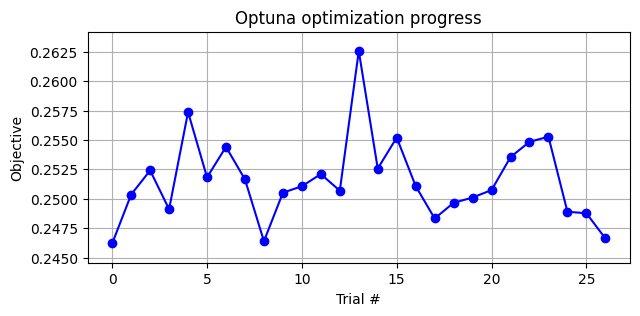

In [7]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-07-29 22:50:03,901] A new study created in RDB with name: no-name-2aeadd08-3a31-4020-aa0e-9580d0efdc6c



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005773184685187452, 'ETA_MIN': 1.9829234182300196e-05, 'WEIGHT_DECAY': 0.00022923411505395972, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



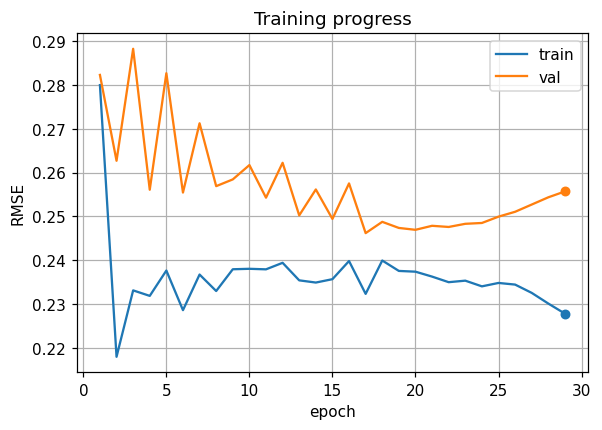

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2800 • val=0.2823 • lr=5.77e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2179 • val=0.2627 • lr=5.76e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2331 • val=0.2883 • lr=5.74e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2319 • val=0.2561 • lr=5.71e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2376 • val=0.2827 • lr=5.68e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2286 • val=0.2555 • lr=5.64e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2367 • val=0.2713 • lr=5.59e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2330 • val=0.2569 • lr=5.53e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2379 • val=0.2585 • lr=5.47e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2380 • val=0.2617 • lr=5.40e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2379 • val=0.2543 • lr=5.32e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2394 • val=0.2623 • lr=5.24e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2354 • val=0.2502 • lr=5.15e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2349 • val=0.2562 • lr=5.06e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2357 • val=0.2494 • lr=4.96e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2398 • val=0.2576 • lr=4.85e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2323 • val=0.2462 • lr=4.74e-04
Saved new best model: GOOGL_0.2462.pth


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2399 • val=0.2488 • lr=4.63e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2376 • val=0.2474 • lr=4.51e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2374 • val=0.2470 • lr=4.38e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2363 • val=0.2479 • lr=4.25e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2350 • val=0.2476 • lr=4.12e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2353 • val=0.2483 • lr=3.99e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2340 • val=0.2485 • lr=3.85e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2348 • val=0.2500 • lr=3.71e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2344 • val=0.2511 • lr=3.57e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2325 • val=0.2527 • lr=3.42e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2301 • val=0.2544 • lr=3.28e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2278 • val=0.2557 • lr=3.13e-04
Early stopping at epoch 29


[I 2025-07-29 23:13:03,611] Trial 0 finished with value: 0.24619641677456153 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005773184685187452, 'ETA_MIN': 1.9829234182300196e-05, 'WEIGHT_DECAY': 0.00022923411505395972}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 1 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007231969805582191, 'ETA_MIN': 1.4075532983658337e-05, 'WEIGHT_DECAY': 0.00010339569512984403, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



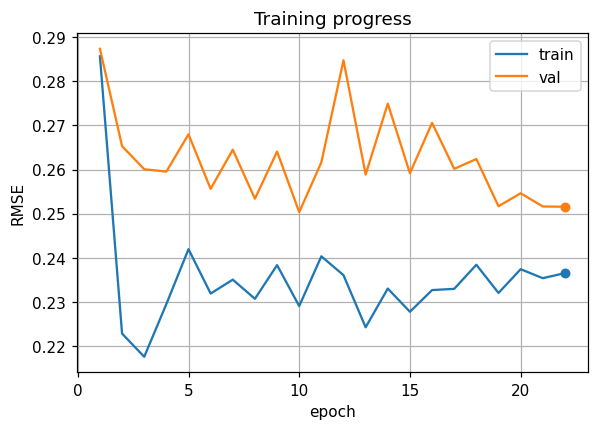

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2857 • val=0.2874 • lr=7.23e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2229 • val=0.2653 • lr=7.21e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2176 • val=0.2601 • lr=7.19e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2295 • val=0.2595 • lr=7.16e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2420 • val=0.2680 • lr=7.11e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2319 • val=0.2556 • lr=7.06e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2351 • val=0.2645 • lr=7.00e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2307 • val=0.2534 • lr=6.93e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2384 • val=0.2641 • lr=6.85e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2291 • val=0.2504 • lr=6.76e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2403 • val=0.2616 • lr=6.66e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2361 • val=0.2848 • lr=6.56e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2243 • val=0.2589 • lr=6.44e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2330 • val=0.2749 • lr=6.32e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2278 • val=0.2592 • lr=6.20e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2327 • val=0.2706 • lr=6.06e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2330 • val=0.2602 • lr=5.92e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2384 • val=0.2624 • lr=5.77e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2320 • val=0.2517 • lr=5.62e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2374 • val=0.2546 • lr=5.46e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2354 • val=0.2516 • lr=5.30e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2365 • val=0.2516 • lr=5.13e-04
Early stopping at epoch 22


[I 2025-07-29 23:30:03,332] Trial 1 finished with value: 0.2503564033298728 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007231969805582191, 'ETA_MIN': 1.4075532983658337e-05, 'WEIGHT_DECAY': 0.00010339569512984403}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 2 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0007196013103370215, 'ETA_MIN': 9.91794315879101e-06, 'WEIGHT_DECAY': 0.00017470191004388534, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



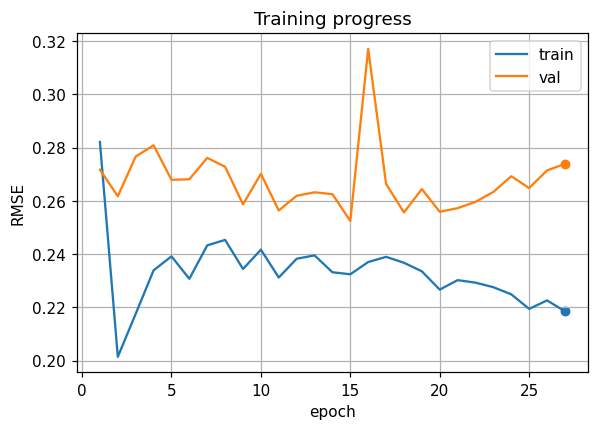

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2821 • val=0.2717 • lr=7.19e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2014 • val=0.2617 • lr=7.18e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2176 • val=0.2766 • lr=7.15e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2339 • val=0.2809 • lr=7.12e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2391 • val=0.2679 • lr=7.08e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2307 • val=0.2681 • lr=7.02e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2433 • val=0.2761 • lr=6.96e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2453 • val=0.2728 • lr=6.89e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2344 • val=0.2587 • lr=6.81e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2417 • val=0.2701 • lr=6.72e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2312 • val=0.2564 • lr=6.63e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2382 • val=0.2619 • lr=6.52e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2395 • val=0.2632 • lr=6.41e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2332 • val=0.2625 • lr=6.29e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2324 • val=0.2524 • lr=6.16e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2370 • val=0.3171 • lr=6.02e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2390 • val=0.2663 • lr=5.88e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2367 • val=0.2556 • lr=5.74e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2335 • val=0.2644 • lr=5.58e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2266 • val=0.2559 • lr=5.42e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2302 • val=0.2572 • lr=5.26e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2293 • val=0.2596 • lr=5.09e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2276 • val=0.2633 • lr=4.92e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2249 • val=0.2692 • lr=4.75e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2194 • val=0.2648 • lr=4.57e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2226 • val=0.2714 • lr=4.39e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2185 • val=0.2739 • lr=4.21e-04
Early stopping at epoch 27


[I 2025-07-29 23:50:36,722] Trial 2 finished with value: 0.25241014969528314 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0007196013103370215, 'ETA_MIN': 9.91794315879101e-06, 'WEIGHT_DECAY': 0.00017470191004388534}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 3 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0008519942604733517, 'ETA_MIN': 1.896216699367495e-05, 'WEIGHT_DECAY': 0.000367425368665199, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



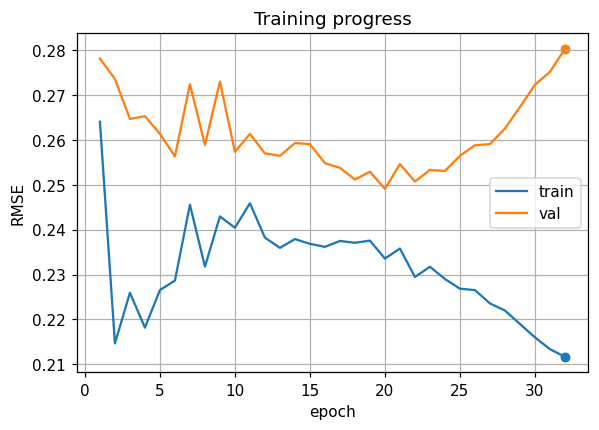

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2641 • val=0.2782 • lr=8.51e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2146 • val=0.2736 • lr=8.50e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2259 • val=0.2647 • lr=8.47e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2182 • val=0.2653 • lr=8.43e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2265 • val=0.2614 • lr=8.38e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2286 • val=0.2563 • lr=8.32e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2456 • val=0.2725 • lr=8.24e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2318 • val=0.2589 • lr=8.16e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2430 • val=0.2730 • lr=8.07e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2404 • val=0.2574 • lr=7.96e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2459 • val=0.2614 • lr=7.85e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2382 • val=0.2570 • lr=7.73e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2360 • val=0.2565 • lr=7.59e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2379 • val=0.2593 • lr=7.45e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2368 • val=0.2591 • lr=7.30e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2362 • val=0.2548 • lr=7.14e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2375 • val=0.2538 • lr=6.98e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2371 • val=0.2512 • lr=6.81e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2376 • val=0.2529 • lr=6.63e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2336 • val=0.2491 • lr=6.44e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2358 • val=0.2546 • lr=6.25e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2295 • val=0.2507 • lr=6.05e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2317 • val=0.2533 • lr=5.85e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2290 • val=0.2531 • lr=5.65e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2268 • val=0.2565 • lr=5.44e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2265 • val=0.2588 • lr=5.22e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2236 • val=0.2591 • lr=5.01e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2220 • val=0.2626 • lr=4.79e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2190 • val=0.2674 • lr=4.58e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2160 • val=0.2723 • lr=4.36e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2134 • val=0.2752 • lr=4.14e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-30 00:15:00,368] Trial 3 finished with value: 0.24910836250024038 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0008519942604733517, 'ETA_MIN': 1.896216699367495e-05, 'WEIGHT_DECAY': 0.000367425368665199}. Best is trial 0 with value: 0.24619641677456153.


Epoch 032 • train=0.2116 • val=0.2804 • lr=3.92e-04
Early stopping at epoch 32

▶ Trial 4 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005725751430883239, 'ETA_MIN': 6.506683465498548e-06, 'WEIGHT_DECAY': 0.00016304635559721083, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



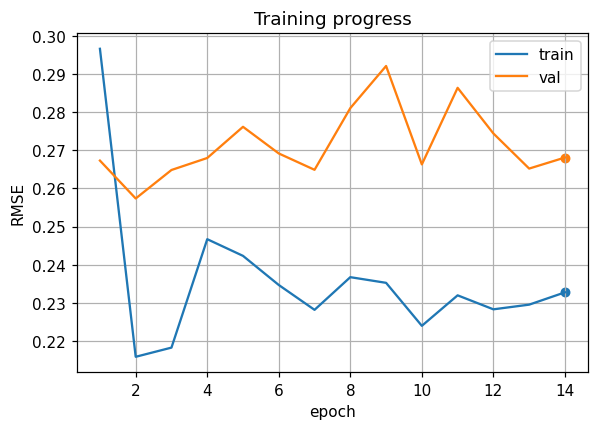

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2966 • val=0.2673 • lr=5.72e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2159 • val=0.2574 • lr=5.71e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2183 • val=0.2648 • lr=5.69e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2467 • val=0.2680 • lr=5.66e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2423 • val=0.2762 • lr=5.63e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2347 • val=0.2692 • lr=5.59e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2282 • val=0.2649 • lr=5.54e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2367 • val=0.2811 • lr=5.48e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2353 • val=0.2921 • lr=5.42e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2240 • val=0.2663 • lr=5.35e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2320 • val=0.2864 • lr=5.27e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2283 • val=0.2744 • lr=5.19e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2295 • val=0.2652 • lr=5.10e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2328 • val=0.2681 • lr=5.00e-04
Early stopping at epoch 14


[I 2025-07-30 00:25:41,247] Trial 4 finished with value: 0.25737535500390485 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005725751430883239, 'ETA_MIN': 6.506683465498548e-06, 'WEIGHT_DECAY': 0.00016304635559721083}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 5 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0006621030481527324, 'ETA_MIN': 1.1419498037378394e-05, 'WEIGHT_DECAY': 0.00013325284017209744, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



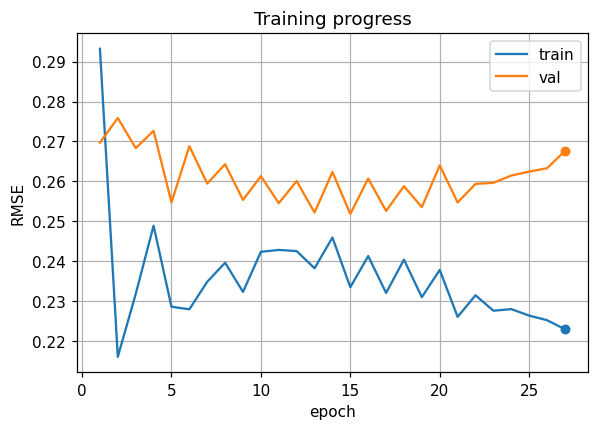

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2932 • val=0.2697 • lr=6.62e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2160 • val=0.2759 • lr=6.60e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2317 • val=0.2683 • lr=6.58e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2489 • val=0.2726 • lr=6.55e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2286 • val=0.2547 • lr=6.51e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2279 • val=0.2688 • lr=6.46e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2348 • val=0.2594 • lr=6.41e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2396 • val=0.2643 • lr=6.34e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2323 • val=0.2554 • lr=6.27e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2423 • val=0.2613 • lr=6.19e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2428 • val=0.2545 • lr=6.10e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2425 • val=0.2601 • lr=6.00e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2382 • val=0.2522 • lr=5.90e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2459 • val=0.2623 • lr=5.79e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2335 • val=0.2518 • lr=5.67e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2413 • val=0.2607 • lr=5.55e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2320 • val=0.2526 • lr=5.42e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2404 • val=0.2588 • lr=5.28e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2310 • val=0.2535 • lr=5.14e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2378 • val=0.2640 • lr=5.00e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2260 • val=0.2547 • lr=4.85e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2314 • val=0.2594 • lr=4.69e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2276 • val=0.2596 • lr=4.54e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2280 • val=0.2615 • lr=4.38e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2264 • val=0.2624 • lr=4.21e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2252 • val=0.2633 • lr=4.05e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-30 00:46:23,103] Trial 5 finished with value: 0.2518232896171096 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0006621030481527324, 'ETA_MIN': 1.1419498037378394e-05, 'WEIGHT_DECAY': 0.00013325284017209744}. Best is trial 0 with value: 0.24619641677456153.


Epoch 027 • train=0.2229 • val=0.2676 • lr=3.88e-04
Early stopping at epoch 27

▶ Trial 6 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0008993832998321131, 'ETA_MIN': 7.678844585615737e-06, 'WEIGHT_DECAY': 0.00022687699657136847, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



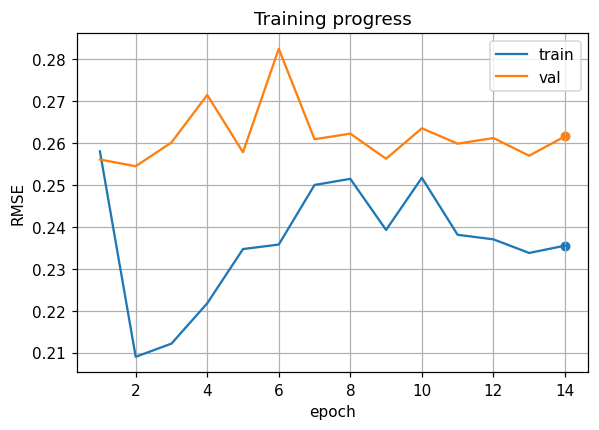

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2580 • val=0.2560 • lr=8.99e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2090 • val=0.2544 • lr=8.97e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2122 • val=0.2601 • lr=8.94e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2218 • val=0.2714 • lr=8.90e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2347 • val=0.2577 • lr=8.84e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2358 • val=0.2824 • lr=8.78e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2500 • val=0.2609 • lr=8.70e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2514 • val=0.2622 • lr=8.61e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2392 • val=0.2562 • lr=8.51e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2517 • val=0.2635 • lr=8.40e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2381 • val=0.2598 • lr=8.28e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2370 • val=0.2611 • lr=8.14e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2338 • val=0.2569 • lr=8.00e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-30 00:57:10,483] Trial 6 finished with value: 0.2544131798040477 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0008993832998321131, 'ETA_MIN': 7.678844585615737e-06, 'WEIGHT_DECAY': 0.00022687699657136847}. Best is trial 0 with value: 0.24619641677456153.


Epoch 014 • train=0.2355 • val=0.2615 • lr=7.85e-04
Early stopping at epoch 14

▶ Trial 7 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0008439318091021619, 'ETA_MIN': 1.699973132090245e-05, 'WEIGHT_DECAY': 0.00042238774170449473, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



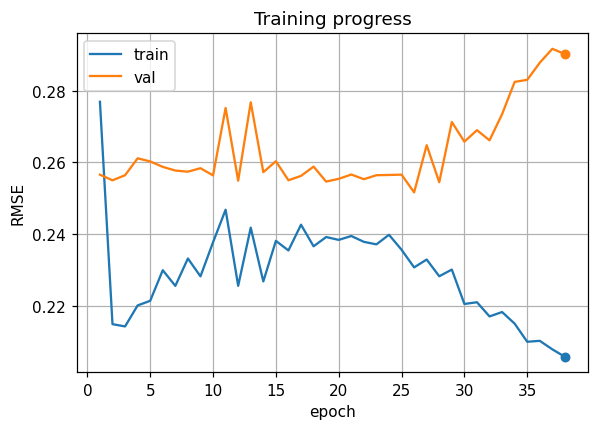

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2769 • val=0.2566 • lr=8.43e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2149 • val=0.2550 • lr=8.42e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2142 • val=0.2564 • lr=8.39e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2201 • val=0.2611 • lr=8.35e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2214 • val=0.2603 • lr=8.30e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2299 • val=0.2588 • lr=8.24e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2256 • val=0.2577 • lr=8.17e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2332 • val=0.2574 • lr=8.08e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2282 • val=0.2584 • lr=7.99e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2377 • val=0.2564 • lr=7.89e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2468 • val=0.2752 • lr=7.77e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2256 • val=0.2549 • lr=7.65e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2418 • val=0.2768 • lr=7.52e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2268 • val=0.2573 • lr=7.38e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2381 • val=0.2603 • lr=7.23e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2354 • val=0.2550 • lr=7.07e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2426 • val=0.2562 • lr=6.91e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2366 • val=0.2588 • lr=6.74e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2392 • val=0.2547 • lr=6.56e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2384 • val=0.2554 • lr=6.38e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2395 • val=0.2566 • lr=6.18e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2378 • val=0.2553 • lr=5.99e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2371 • val=0.2564 • lr=5.79e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2398 • val=0.2565 • lr=5.59e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2356 • val=0.2566 • lr=5.38e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2307 • val=0.2516 • lr=5.17e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2329 • val=0.2648 • lr=4.95e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2282 • val=0.2545 • lr=4.74e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2301 • val=0.2713 • lr=4.52e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2205 • val=0.2658 • lr=4.31e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2210 • val=0.2690 • lr=4.09e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2170 • val=0.2662 • lr=3.88e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2183 • val=0.2735 • lr=3.66e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2150 • val=0.2825 • lr=3.45e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2100 • val=0.2830 • lr=3.24e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2102 • val=0.2878 • lr=3.03e-04


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2078 • val=0.2917 • lr=2.83e-04


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-30 01:26:29,278] Trial 7 finished with value: 0.2516469256063917 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0008439318091021619, 'ETA_MIN': 1.699973132090245e-05, 'WEIGHT_DECAY': 0.00042238774170449473}. Best is trial 0 with value: 0.24619641677456153.


Epoch 038 • train=0.2058 • val=0.2902 • lr=2.63e-04
Early stopping at epoch 38

▶ Trial 8 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006997872262982847, 'ETA_MIN': 1.2221861372240842e-05, 'WEIGHT_DECAY': 0.00019917163363840788, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



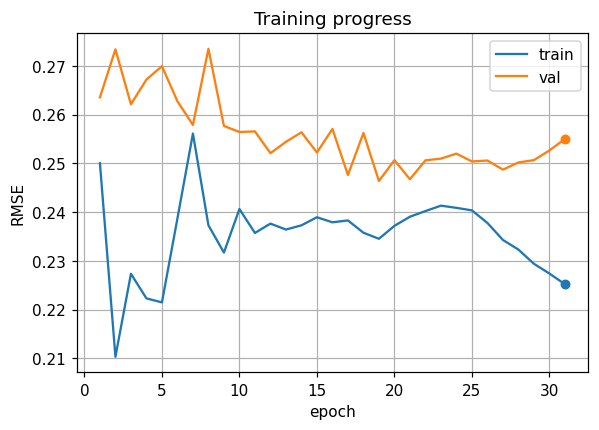

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2500 • val=0.2636 • lr=6.99e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2103 • val=0.2734 • lr=6.98e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2273 • val=0.2621 • lr=6.96e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2223 • val=0.2672 • lr=6.92e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2215 • val=0.2700 • lr=6.88e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2387 • val=0.2628 • lr=6.83e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2561 • val=0.2579 • lr=6.77e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2373 • val=0.2735 • lr=6.70e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2317 • val=0.2577 • lr=6.62e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2406 • val=0.2565 • lr=6.54e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2357 • val=0.2566 • lr=6.44e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2376 • val=0.2521 • lr=6.34e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2364 • val=0.2544 • lr=6.23e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2373 • val=0.2564 • lr=6.12e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2389 • val=0.2522 • lr=5.99e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2379 • val=0.2571 • lr=5.86e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2383 • val=0.2476 • lr=5.73e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2358 • val=0.2563 • lr=5.58e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2345 • val=0.2464 • lr=5.43e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2372 • val=0.2507 • lr=5.28e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2391 • val=0.2468 • lr=5.12e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2402 • val=0.2506 • lr=4.96e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2413 • val=0.2510 • lr=4.79e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2409 • val=0.2520 • lr=4.63e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2404 • val=0.2504 • lr=4.45e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2378 • val=0.2506 • lr=4.28e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2343 • val=0.2487 • lr=4.10e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2323 • val=0.2502 • lr=3.92e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2294 • val=0.2507 • lr=3.74e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2274 • val=0.2527 • lr=3.56e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2252 • val=0.2550 • lr=3.38e-04
Early stopping at epoch 31


[I 2025-07-30 01:50:27,684] Trial 8 finished with value: 0.246387212251007 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006997872262982847, 'ETA_MIN': 1.2221861372240842e-05, 'WEIGHT_DECAY': 0.00019917163363840788}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 9 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0007736368932300402, 'ETA_MIN': 1.6270602959937142e-05, 'WEIGHT_DECAY': 0.00030462678768843104, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



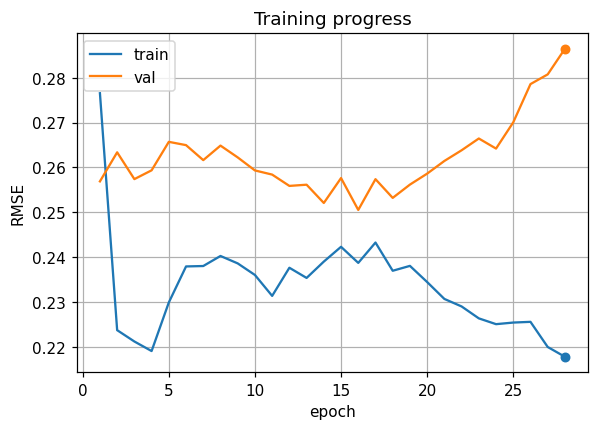

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2766 • val=0.2569 • lr=7.73e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2237 • val=0.2634 • lr=7.72e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2212 • val=0.2574 • lr=7.69e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2190 • val=0.2594 • lr=7.65e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2299 • val=0.2657 • lr=7.61e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2379 • val=0.2650 • lr=7.55e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2380 • val=0.2616 • lr=7.49e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2402 • val=0.2649 • lr=7.41e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2386 • val=0.2622 • lr=7.33e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2360 • val=0.2593 • lr=7.23e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2313 • val=0.2584 • lr=7.13e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2376 • val=0.2559 • lr=7.02e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2353 • val=0.2561 • lr=6.89e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2390 • val=0.2521 • lr=6.77e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2423 • val=0.2576 • lr=6.63e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2387 • val=0.2505 • lr=6.49e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2432 • val=0.2574 • lr=6.34e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2369 • val=0.2532 • lr=6.18e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2380 • val=0.2562 • lr=6.01e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2344 • val=0.2586 • lr=5.85e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2307 • val=0.2614 • lr=5.67e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2290 • val=0.2638 • lr=5.49e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2263 • val=0.2665 • lr=5.31e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2250 • val=0.2642 • lr=5.12e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2254 • val=0.2701 • lr=4.93e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2256 • val=0.2786 • lr=4.74e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2199 • val=0.2808 • lr=4.55e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2178 • val=0.2865 • lr=4.35e-04
Early stopping at epoch 28


[I 2025-07-30 02:12:09,124] Trial 9 finished with value: 0.25051677429023067 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0007736368932300402, 'ETA_MIN': 1.6270602959937142e-05, 'WEIGHT_DECAY': 0.00030462678768843104}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 10 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0005057616623320734, 'ETA_MIN': 1.9914406147536368e-05, 'WEIGHT_DECAY': 1.8551330824420923e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



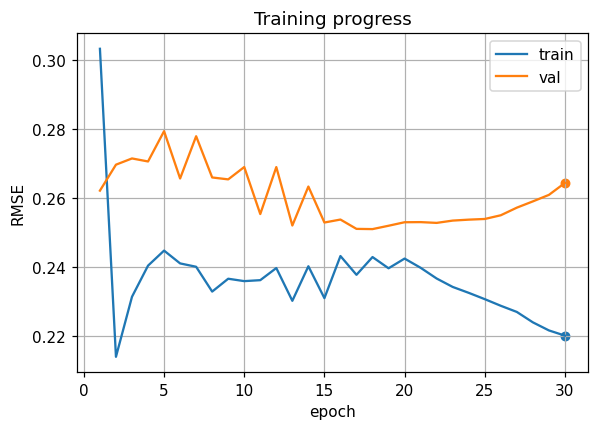

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3033 • val=0.2622 • lr=5.05e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2141 • val=0.2697 • lr=5.04e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2315 • val=0.2715 • lr=5.03e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2405 • val=0.2707 • lr=5.00e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2448 • val=0.2794 • lr=4.98e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2411 • val=0.2657 • lr=4.94e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2402 • val=0.2780 • lr=4.90e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2330 • val=0.2660 • lr=4.85e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2367 • val=0.2655 • lr=4.79e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2360 • val=0.2690 • lr=4.73e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2363 • val=0.2554 • lr=4.67e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2398 • val=0.2690 • lr=4.59e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2303 • val=0.2521 • lr=4.52e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2403 • val=0.2634 • lr=4.44e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2311 • val=0.2530 • lr=4.35e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2433 • val=0.2538 • lr=4.26e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2378 • val=0.2511 • lr=4.16e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2430 • val=0.2511 • lr=4.06e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2397 • val=0.2520 • lr=3.95e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2425 • val=0.2531 • lr=3.84e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2399 • val=0.2531 • lr=3.73e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2368 • val=0.2529 • lr=3.62e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2343 • val=0.2535 • lr=3.50e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2326 • val=0.2538 • lr=3.38e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2308 • val=0.2540 • lr=3.26e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2289 • val=0.2551 • lr=3.14e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2271 • val=0.2573 • lr=3.01e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2241 • val=0.2591 • lr=2.88e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2217 • val=0.2610 • lr=2.76e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2202 • val=0.2644 • lr=2.63e-04
Early stopping at epoch 30


[I 2025-07-30 02:35:21,305] Trial 10 finished with value: 0.2510653248225945 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0005057616623320734, 'ETA_MIN': 1.9914406147536368e-05, 'WEIGHT_DECAY': 1.8551330824420923e-05}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 11 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006135731754519727, 'ETA_MIN': 1.4007999284103979e-05, 'WEIGHT_DECAY': 0.00027809511632360105, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



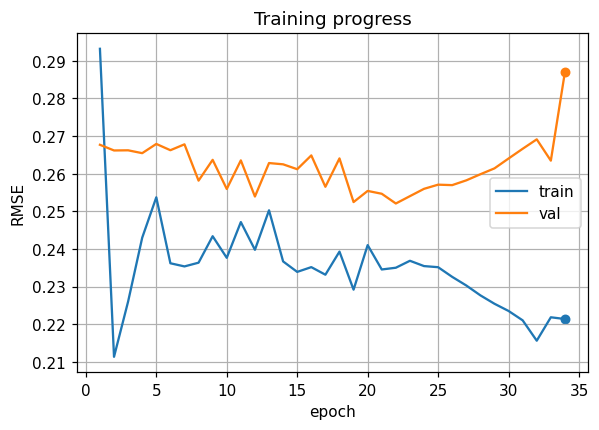

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2932 • val=0.2677 • lr=6.13e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2114 • val=0.2662 • lr=6.12e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2261 • val=0.2662 • lr=6.10e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2430 • val=0.2655 • lr=6.07e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2537 • val=0.2679 • lr=6.03e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2362 • val=0.2662 • lr=5.99e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2354 • val=0.2678 • lr=5.94e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2364 • val=0.2582 • lr=5.88e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2434 • val=0.2637 • lr=5.81e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2377 • val=0.2560 • lr=5.74e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2472 • val=0.2635 • lr=5.65e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2398 • val=0.2540 • lr=5.56e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2503 • val=0.2628 • lr=5.47e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2367 • val=0.2625 • lr=5.37e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2339 • val=0.2612 • lr=5.26e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2352 • val=0.2649 • lr=5.15e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2332 • val=0.2565 • lr=5.03e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2393 • val=0.2641 • lr=4.90e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2292 • val=0.2525 • lr=4.77e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2410 • val=0.2554 • lr=4.64e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2346 • val=0.2547 • lr=4.50e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2350 • val=0.2521 • lr=4.36e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2369 • val=0.2541 • lr=4.21e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2355 • val=0.2560 • lr=4.07e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2352 • val=0.2571 • lr=3.92e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2326 • val=0.2570 • lr=3.76e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2303 • val=0.2582 • lr=3.61e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2277 • val=0.2599 • lr=3.45e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2255 • val=0.2614 • lr=3.30e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2236 • val=0.2640 • lr=3.14e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2211 • val=0.2666 • lr=2.98e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2157 • val=0.2691 • lr=2.83e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2219 • val=0.2635 • lr=2.67e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2214 • val=0.2870 • lr=2.52e-04
Early stopping at epoch 34


[I 2025-07-30 03:01:43,213] Trial 11 finished with value: 0.25209833225854567 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006135731754519727, 'ETA_MIN': 1.4007999284103979e-05, 'WEIGHT_DECAY': 0.00027809511632360105}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 12 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.000510341465910466, 'ETA_MIN': 9.50886472396596e-06, 'WEIGHT_DECAY': 0.0002395039522027038, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



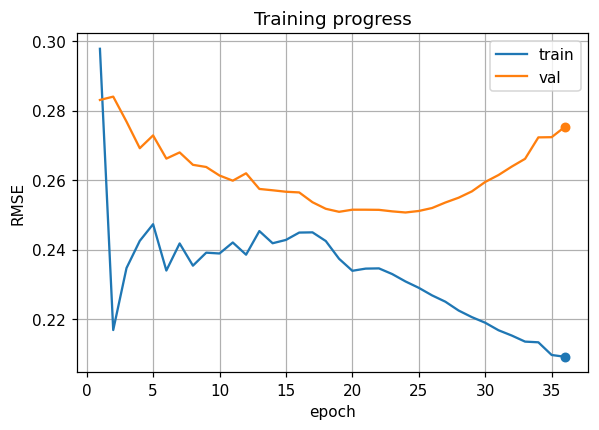

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2977 • val=0.2830 • lr=5.10e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2169 • val=0.2840 • lr=5.09e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2347 • val=0.2768 • lr=5.07e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2425 • val=0.2692 • lr=5.05e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2473 • val=0.2728 • lr=5.02e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2340 • val=0.2662 • lr=4.98e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2418 • val=0.2680 • lr=4.94e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2354 • val=0.2644 • lr=4.89e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2391 • val=0.2638 • lr=4.83e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2389 • val=0.2613 • lr=4.77e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2421 • val=0.2598 • lr=4.70e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2386 • val=0.2620 • lr=4.63e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2453 • val=0.2575 • lr=4.55e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2418 • val=0.2571 • lr=4.46e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2428 • val=0.2566 • lr=4.37e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2449 • val=0.2565 • lr=4.28e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2450 • val=0.2536 • lr=4.18e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2425 • val=0.2517 • lr=4.07e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2374 • val=0.2509 • lr=3.96e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2339 • val=0.2515 • lr=3.85e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2345 • val=0.2515 • lr=3.74e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2346 • val=0.2514 • lr=3.62e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2330 • val=0.2510 • lr=3.50e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2309 • val=0.2507 • lr=3.38e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2290 • val=0.2511 • lr=3.25e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2269 • val=0.2520 • lr=3.12e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2250 • val=0.2536 • lr=2.99e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2225 • val=0.2549 • lr=2.86e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2206 • val=0.2568 • lr=2.73e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2190 • val=0.2595 • lr=2.60e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2168 • val=0.2615 • lr=2.47e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2153 • val=0.2639 • lr=2.34e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2136 • val=0.2661 • lr=2.21e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2134 • val=0.2723 • lr=2.08e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2097 • val=0.2723 • lr=1.95e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2092 • val=0.2753 • lr=1.83e-04
Early stopping at epoch 36


[I 2025-07-30 03:29:39,448] Trial 12 finished with value: 0.2506863740528451 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.000510341465910466, 'ETA_MIN': 9.50886472396596e-06, 'WEIGHT_DECAY': 0.0002395039522027038}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 13 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0009950581202979602, 'ETA_MIN': 1.3013495418541886e-05, 'WEIGHT_DECAY': 0.00048171518141195, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



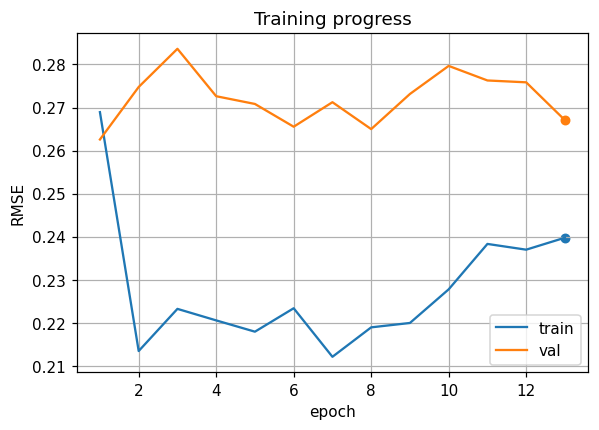

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2689 • val=0.2626 • lr=9.94e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2135 • val=0.2748 • lr=9.92e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2232 • val=0.2836 • lr=9.89e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2206 • val=0.2726 • lr=9.84e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2180 • val=0.2708 • lr=9.78e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2234 • val=0.2655 • lr=9.71e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2121 • val=0.2712 • lr=9.63e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2190 • val=0.2650 • lr=9.53e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2200 • val=0.2731 • lr=9.42e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2278 • val=0.2797 • lr=9.29e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2383 • val=0.2763 • lr=9.16e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2370 • val=0.2759 • lr=9.02e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2398 • val=0.2671 • lr=8.86e-04
Early stopping at epoch 13


[I 2025-07-30 03:39:45,271] Trial 13 finished with value: 0.2625744020831302 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0009950581202979602, 'ETA_MIN': 1.3013495418541886e-05, 'WEIGHT_DECAY': 0.00048171518141195}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 14 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0006305992182588945, 'ETA_MIN': 1.6132846590513984e-05, 'WEIGHT_DECAY': 5.8736896864710144e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



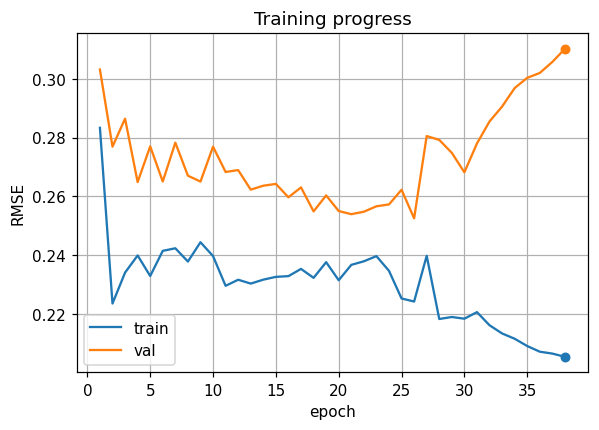

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2833 • val=0.3031 • lr=6.30e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2236 • val=0.2769 • lr=6.29e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2341 • val=0.2864 • lr=6.27e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2400 • val=0.2649 • lr=6.24e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2330 • val=0.2770 • lr=6.20e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2415 • val=0.2651 • lr=6.16e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2424 • val=0.2783 • lr=6.10e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2379 • val=0.2671 • lr=6.04e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2444 • val=0.2651 • lr=5.97e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2397 • val=0.2769 • lr=5.90e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2296 • val=0.2683 • lr=5.81e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2317 • val=0.2690 • lr=5.72e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2304 • val=0.2623 • lr=5.62e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2317 • val=0.2637 • lr=5.52e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2327 • val=0.2643 • lr=5.41e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2329 • val=0.2597 • lr=5.29e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2354 • val=0.2631 • lr=5.17e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2323 • val=0.2549 • lr=5.04e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2377 • val=0.2604 • lr=4.91e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2315 • val=0.2551 • lr=4.77e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2368 • val=0.2540 • lr=4.63e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2380 • val=0.2548 • lr=4.49e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2397 • val=0.2567 • lr=4.34e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2347 • val=0.2573 • lr=4.19e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2253 • val=0.2623 • lr=4.03e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2243 • val=0.2526 • lr=3.87e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2398 • val=0.2805 • lr=3.72e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2184 • val=0.2792 • lr=3.56e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2190 • val=0.2748 • lr=3.40e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2185 • val=0.2682 • lr=3.24e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2207 • val=0.2780 • lr=3.08e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2162 • val=0.2855 • lr=2.92e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2135 • val=0.2905 • lr=2.76e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2117 • val=0.2968 • lr=2.60e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2092 • val=0.3003 • lr=2.44e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2073 • val=0.3020 • lr=2.29e-04


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2066 • val=0.3057 • lr=2.14e-04


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.2055 • val=0.3102 • lr=1.99e-04
Early stopping at epoch 38


[I 2025-07-30 04:09:11,712] Trial 14 finished with value: 0.25257021321664425 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0006305992182588945, 'ETA_MIN': 1.6132846590513984e-05, 'WEIGHT_DECAY': 5.8736896864710144e-05}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 15 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005675323705438967, 'ETA_MIN': 1.1322890820597492e-05, 'WEIGHT_DECAY': 0.00033440532876544485, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



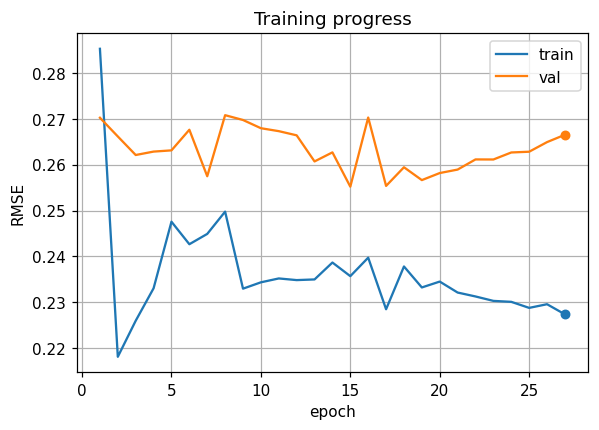

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2853 • val=0.2702 • lr=5.67e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2181 • val=0.2662 • lr=5.66e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2260 • val=0.2621 • lr=5.64e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2330 • val=0.2629 • lr=5.62e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2476 • val=0.2631 • lr=5.58e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2427 • val=0.2676 • lr=5.54e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2449 • val=0.2575 • lr=5.49e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2498 • val=0.2708 • lr=5.44e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2330 • val=0.2697 • lr=5.37e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2343 • val=0.2680 • lr=5.30e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2352 • val=0.2673 • lr=5.23e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2348 • val=0.2664 • lr=5.15e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2350 • val=0.2607 • lr=5.06e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2387 • val=0.2627 • lr=4.96e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2357 • val=0.2552 • lr=4.86e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2397 • val=0.2703 • lr=4.76e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2285 • val=0.2554 • lr=4.65e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2378 • val=0.2594 • lr=4.53e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2332 • val=0.2566 • lr=4.41e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2345 • val=0.2582 • lr=4.29e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2321 • val=0.2589 • lr=4.16e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2313 • val=0.2611 • lr=4.03e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2303 • val=0.2611 • lr=3.89e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2301 • val=0.2627 • lr=3.76e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2288 • val=0.2628 • lr=3.62e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2296 • val=0.2649 • lr=3.47e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2274 • val=0.2665 • lr=3.33e-04
Early stopping at epoch 27


[I 2025-07-30 04:30:07,074] Trial 15 finished with value: 0.2552032817544347 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005675323705438967, 'ETA_MIN': 1.1322890820597492e-05, 'WEIGHT_DECAY': 0.00033440532876544485}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 16 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006782958374292676, 'ETA_MIN': 1.7377892862008354e-05, 'WEIGHT_DECAY': 0.00020208739382701366, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



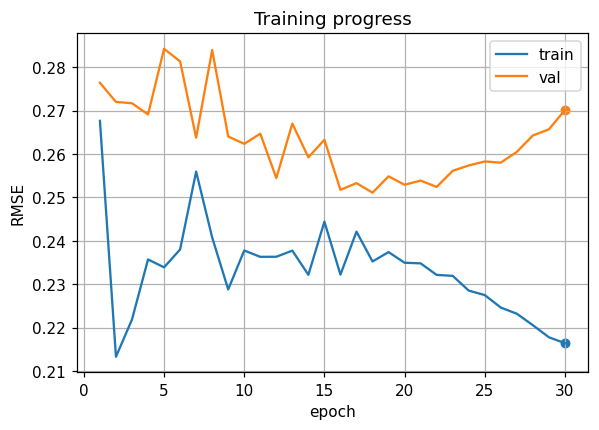

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2676 • val=0.2764 • lr=6.78e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2133 • val=0.2720 • lr=6.77e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2219 • val=0.2717 • lr=6.74e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2357 • val=0.2691 • lr=6.71e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2339 • val=0.2842 • lr=6.67e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2380 • val=0.2813 • lr=6.62e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2559 • val=0.2637 • lr=6.56e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2408 • val=0.2840 • lr=6.50e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2288 • val=0.2640 • lr=6.42e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2378 • val=0.2623 • lr=6.34e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2363 • val=0.2647 • lr=6.25e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2363 • val=0.2545 • lr=6.15e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2377 • val=0.2670 • lr=6.05e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2322 • val=0.2592 • lr=5.94e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2444 • val=0.2633 • lr=5.82e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2322 • val=0.2517 • lr=5.69e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2421 • val=0.2533 • lr=5.56e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2352 • val=0.2511 • lr=5.42e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2374 • val=0.2548 • lr=5.28e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2349 • val=0.2529 • lr=5.13e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2348 • val=0.2539 • lr=4.98e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2321 • val=0.2524 • lr=4.83e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2319 • val=0.2561 • lr=4.67e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2285 • val=0.2574 • lr=4.50e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2275 • val=0.2583 • lr=4.34e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2246 • val=0.2580 • lr=4.17e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2232 • val=0.2605 • lr=4.00e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2205 • val=0.2643 • lr=3.83e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2178 • val=0.2657 • lr=3.65e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2164 • val=0.2701 • lr=3.48e-04
Early stopping at epoch 30


[I 2025-07-30 04:53:22,391] Trial 16 finished with value: 0.2510806156839868 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006782958374292676, 'ETA_MIN': 1.7377892862008354e-05, 'WEIGHT_DECAY': 0.00020208739382701366}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 17 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007698240199308195, 'ETA_MIN': 1.4981028832488754e-05, 'WEIGHT_DECAY': 9.920025613256142e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



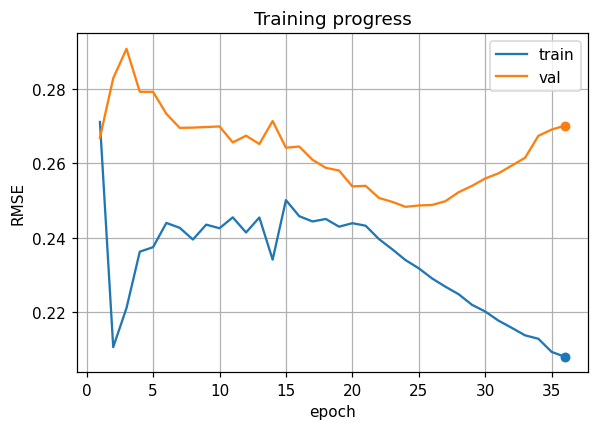

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2711 • val=0.2669 • lr=7.69e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2106 • val=0.2829 • lr=7.68e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2211 • val=0.2908 • lr=7.65e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2363 • val=0.2793 • lr=7.62e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2375 • val=0.2792 • lr=7.57e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2440 • val=0.2733 • lr=7.51e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2427 • val=0.2696 • lr=7.45e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2395 • val=0.2696 • lr=7.37e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2435 • val=0.2698 • lr=7.29e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2426 • val=0.2699 • lr=7.19e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2455 • val=0.2656 • lr=7.09e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2414 • val=0.2674 • lr=6.98e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2455 • val=0.2652 • lr=6.86e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2341 • val=0.2714 • lr=6.73e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2501 • val=0.2642 • lr=6.60e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2458 • val=0.2645 • lr=6.45e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2444 • val=0.2610 • lr=6.30e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2451 • val=0.2588 • lr=6.15e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2430 • val=0.2581 • lr=5.98e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2439 • val=0.2538 • lr=5.81e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2432 • val=0.2540 • lr=5.64e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2397 • val=0.2507 • lr=5.46e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2369 • val=0.2497 • lr=5.28e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2340 • val=0.2483 • lr=5.09e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2318 • val=0.2487 • lr=4.90e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2291 • val=0.2488 • lr=4.71e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2269 • val=0.2498 • lr=4.52e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2248 • val=0.2523 • lr=4.32e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2220 • val=0.2539 • lr=4.12e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2202 • val=0.2559 • lr=3.93e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2177 • val=0.2573 • lr=3.73e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2158 • val=0.2594 • lr=3.53e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2138 • val=0.2615 • lr=3.34e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2129 • val=0.2674 • lr=3.14e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2093 • val=0.2691 • lr=2.95e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2080 • val=0.2701 • lr=2.76e-04
Early stopping at epoch 36


[I 2025-07-30 05:21:14,907] Trial 17 finished with value: 0.24832251699306135 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007698240199308195, 'ETA_MIN': 1.4981028832488754e-05, 'WEIGHT_DECAY': 9.920025613256142e-05}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 18 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005746204227906125, 'ETA_MIN': 9.474149430716027e-06, 'WEIGHT_DECAY': 0.00037740035658714193, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



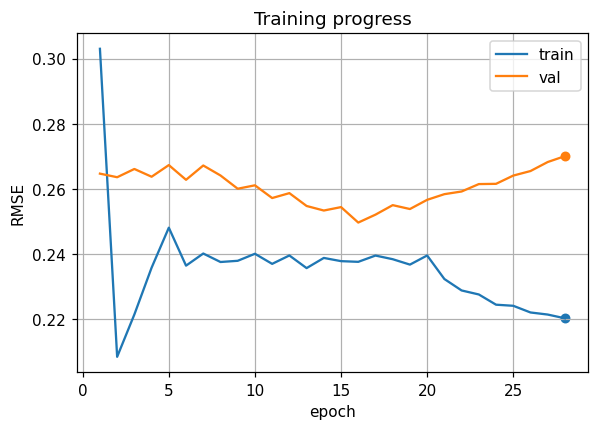

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3030 • val=0.2647 • lr=5.74e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2084 • val=0.2636 • lr=5.73e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2214 • val=0.2661 • lr=5.71e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2358 • val=0.2637 • lr=5.68e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2481 • val=0.2673 • lr=5.65e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2364 • val=0.2628 • lr=5.61e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2401 • val=0.2672 • lr=5.56e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2375 • val=0.2641 • lr=5.50e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2379 • val=0.2601 • lr=5.44e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2401 • val=0.2611 • lr=5.37e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2370 • val=0.2572 • lr=5.29e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2395 • val=0.2587 • lr=5.21e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2357 • val=0.2548 • lr=5.12e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2388 • val=0.2534 • lr=5.02e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2378 • val=0.2544 • lr=4.92e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2376 • val=0.2497 • lr=4.81e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2395 • val=0.2521 • lr=4.70e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2384 • val=0.2550 • lr=4.58e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2367 • val=0.2538 • lr=4.46e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2395 • val=0.2566 • lr=4.34e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2323 • val=0.2584 • lr=4.21e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2288 • val=0.2592 • lr=4.07e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2276 • val=0.2615 • lr=3.94e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2244 • val=0.2616 • lr=3.80e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2241 • val=0.2641 • lr=3.65e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2220 • val=0.2655 • lr=3.51e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2214 • val=0.2683 • lr=3.36e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2202 • val=0.2701 • lr=3.22e-04
Early stopping at epoch 28


[I 2025-07-30 05:42:57,297] Trial 18 finished with value: 0.24965536127233773 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0005746204227906125, 'ETA_MIN': 9.474149430716027e-06, 'WEIGHT_DECAY': 0.00037740035658714193}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 19 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0006843714467254743, 'ETA_MIN': 5.6203456249786616e-06, 'WEIGHT_DECAY': 0.0002727377431082996, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



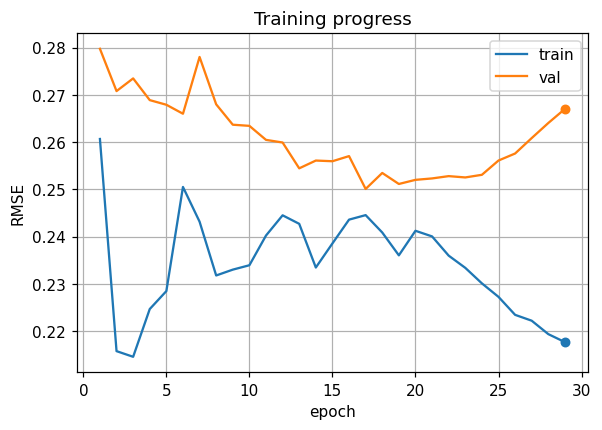

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2607 • val=0.2798 • lr=6.84e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2158 • val=0.2708 • lr=6.83e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2146 • val=0.2735 • lr=6.80e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2247 • val=0.2689 • lr=6.77e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2285 • val=0.2679 • lr=6.73e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2505 • val=0.2660 • lr=6.68e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2432 • val=0.2780 • lr=6.62e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2318 • val=0.2680 • lr=6.55e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2330 • val=0.2637 • lr=6.48e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2340 • val=0.2635 • lr=6.39e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2402 • val=0.2605 • lr=6.30e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2445 • val=0.2599 • lr=6.20e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2427 • val=0.2545 • lr=6.09e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2335 • val=0.2561 • lr=5.97e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2386 • val=0.2560 • lr=5.85e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2436 • val=0.2571 • lr=5.72e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2446 • val=0.2501 • lr=5.59e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2409 • val=0.2535 • lr=5.45e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2361 • val=0.2512 • lr=5.30e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2412 • val=0.2520 • lr=5.15e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2401 • val=0.2523 • lr=4.99e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2360 • val=0.2528 • lr=4.83e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2334 • val=0.2525 • lr=4.67e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2301 • val=0.2531 • lr=4.50e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2273 • val=0.2561 • lr=4.33e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2235 • val=0.2576 • lr=4.16e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2222 • val=0.2609 • lr=3.98e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2194 • val=0.2641 • lr=3.81e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2177 • val=0.2670 • lr=3.63e-04
Early stopping at epoch 29


[I 2025-07-30 06:05:25,696] Trial 19 finished with value: 0.2501053891719213 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.35, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.0006843714467254743, 'ETA_MIN': 5.6203456249786616e-06, 'WEIGHT_DECAY': 0.0002727377431082996}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 20 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0008189454058182854, 'ETA_MIN': 1.2223013892965505e-05, 'WEIGHT_DECAY': 0.00019332926767065756, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



/workspace/my_models/Trading/_Stock_Analysis_/libs/plots.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)


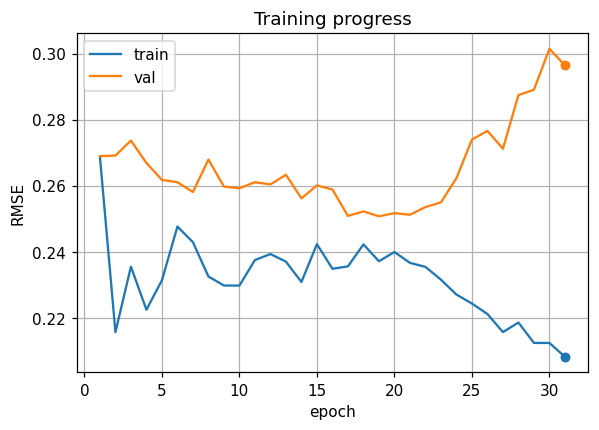

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2688 • val=0.2689 • lr=8.18e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2157 • val=0.2691 • lr=8.17e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2355 • val=0.2737 • lr=8.14e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2225 • val=0.2669 • lr=8.10e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2314 • val=0.2618 • lr=8.05e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2476 • val=0.2610 • lr=7.99e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2429 • val=0.2581 • lr=7.92e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2325 • val=0.2679 • lr=7.84e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2298 • val=0.2598 • lr=7.75e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2298 • val=0.2592 • lr=7.65e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2375 • val=0.2611 • lr=7.54e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2393 • val=0.2604 • lr=7.42e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2370 • val=0.2633 • lr=7.29e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2309 • val=0.2562 • lr=7.16e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2423 • val=0.2601 • lr=7.01e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2349 • val=0.2589 • lr=6.86e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2356 • val=0.2509 • lr=6.70e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2422 • val=0.2522 • lr=6.53e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2371 • val=0.2507 • lr=6.36e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2399 • val=0.2517 • lr=6.18e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2367 • val=0.2512 • lr=5.99e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2354 • val=0.2535 • lr=5.80e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2316 • val=0.2550 • lr=5.60e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2271 • val=0.2623 • lr=5.41e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2244 • val=0.2740 • lr=5.20e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2212 • val=0.2766 • lr=5.00e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2157 • val=0.2712 • lr=4.79e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2186 • val=0.2874 • lr=4.58e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2124 • val=0.2890 • lr=4.37e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2124 • val=0.3014 • lr=4.16e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2082 • val=0.2964 • lr=3.95e-04
Early stopping at epoch 31


[I 2025-07-30 06:29:26,290] Trial 20 finished with value: 0.25074034029861564 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0008189454058182854, 'ETA_MIN': 1.2223013892965505e-05, 'WEIGHT_DECAY': 0.00019332926767065756}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 21 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007785442924700553, 'ETA_MIN': 1.4507255562065855e-05, 'WEIGHT_DECAY': 0.00010260760897134829, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



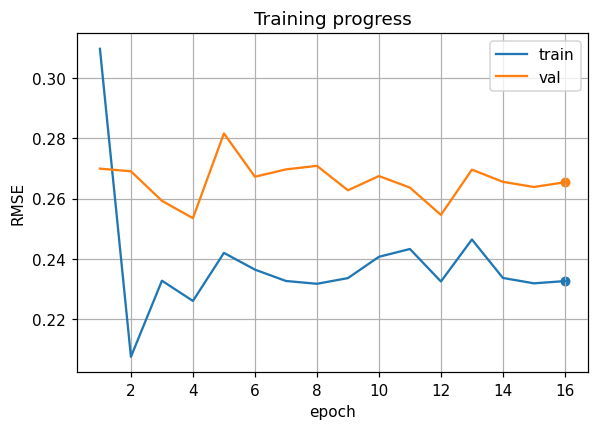

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3097 • val=0.2700 • lr=7.78e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2076 • val=0.2691 • lr=7.76e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2328 • val=0.2593 • lr=7.74e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2261 • val=0.2535 • lr=7.70e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2420 • val=0.2816 • lr=7.66e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2365 • val=0.2673 • lr=7.60e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2327 • val=0.2697 • lr=7.53e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2318 • val=0.2709 • lr=7.46e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2337 • val=0.2628 • lr=7.37e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2407 • val=0.2675 • lr=7.28e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2433 • val=0.2637 • lr=7.17e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2326 • val=0.2546 • lr=7.06e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2465 • val=0.2696 • lr=6.94e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2337 • val=0.2656 • lr=6.81e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2320 • val=0.2639 • lr=6.67e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2327 • val=0.2654 • lr=6.52e-04
Early stopping at epoch 16


[I 2025-07-30 06:41:57,376] Trial 21 finished with value: 0.2535451012478551 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007785442924700553, 'ETA_MIN': 1.4507255562065855e-05, 'WEIGHT_DECAY': 0.00010260760897134829}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 22 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.000906295294450746, 'ETA_MIN': 1.842172948110936e-05, 'WEIGHT_DECAY': 0.00013160114627785088, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



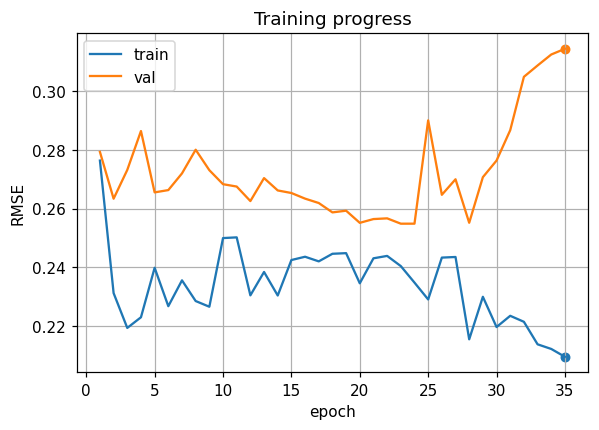

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2763 • val=0.2793 • lr=9.06e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2312 • val=0.2633 • lr=9.04e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2194 • val=0.2731 • lr=9.01e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2230 • val=0.2864 • lr=8.97e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2398 • val=0.2655 • lr=8.91e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2268 • val=0.2663 • lr=8.85e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2356 • val=0.2720 • lr=8.77e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2285 • val=0.2800 • lr=8.68e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2266 • val=0.2730 • lr=8.58e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2500 • val=0.2683 • lr=8.47e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2502 • val=0.2675 • lr=8.35e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2305 • val=0.2625 • lr=8.22e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2384 • val=0.2704 • lr=8.08e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2304 • val=0.2662 • lr=7.93e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2425 • val=0.2653 • lr=7.77e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2436 • val=0.2634 • lr=7.60e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2420 • val=0.2619 • lr=7.42e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2446 • val=0.2587 • lr=7.24e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2448 • val=0.2593 • lr=7.04e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2346 • val=0.2551 • lr=6.85e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2431 • val=0.2564 • lr=6.64e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2439 • val=0.2567 • lr=6.43e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2404 • val=0.2548 • lr=6.22e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2348 • val=0.2548 • lr=6.00e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2291 • val=0.2900 • lr=5.78e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2433 • val=0.2647 • lr=5.55e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2435 • val=0.2700 • lr=5.32e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2155 • val=0.2552 • lr=5.09e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2300 • val=0.2707 • lr=4.86e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2197 • val=0.2763 • lr=4.63e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2235 • val=0.2867 • lr=4.39e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2215 • val=0.3048 • lr=4.16e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2138 • val=0.3087 • lr=3.93e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2122 • val=0.3124 • lr=3.70e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2096 • val=0.3143 • lr=3.48e-04
Early stopping at epoch 35


[I 2025-07-30 07:09:08,531] Trial 22 finished with value: 0.2548461911460249 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.000906295294450746, 'ETA_MIN': 1.842172948110936e-05, 'WEIGHT_DECAY': 0.00013160114627785088}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 23 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007456566184473019, 'ETA_MIN': 1.595901395425041e-05, 'WEIGHT_DECAY': 6.315105166740319e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



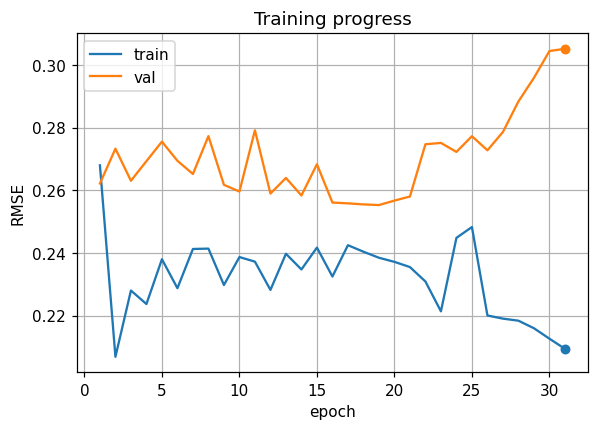

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2680 • val=0.2622 • lr=7.45e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2068 • val=0.2733 • lr=7.44e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2280 • val=0.2630 • lr=7.41e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2237 • val=0.2693 • lr=7.38e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2380 • val=0.2755 • lr=7.33e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2287 • val=0.2694 • lr=7.28e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2413 • val=0.2652 • lr=7.22e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2414 • val=0.2773 • lr=7.14e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2297 • val=0.2617 • lr=7.06e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2387 • val=0.2596 • lr=6.97e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2372 • val=0.2791 • lr=6.87e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2282 • val=0.2590 • lr=6.76e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2397 • val=0.2639 • lr=6.65e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2347 • val=0.2583 • lr=6.52e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2417 • val=0.2683 • lr=6.39e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2325 • val=0.2561 • lr=6.25e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2425 • val=0.2558 • lr=6.11e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2404 • val=0.2555 • lr=5.96e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2385 • val=0.2553 • lr=5.80e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2371 • val=0.2567 • lr=5.63e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2355 • val=0.2580 • lr=5.47e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2309 • val=0.2747 • lr=5.29e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2213 • val=0.2751 • lr=5.12e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2448 • val=0.2722 • lr=4.94e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2483 • val=0.2773 • lr=4.76e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2200 • val=0.2728 • lr=4.57e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2190 • val=0.2786 • lr=4.38e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2184 • val=0.2883 • lr=4.19e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2160 • val=0.2959 • lr=4.00e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2126 • val=0.3044 • lr=3.81e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2094 • val=0.3052 • lr=3.62e-04
Early stopping at epoch 31


[I 2025-07-30 07:33:18,418] Trial 23 finished with value: 0.255277872607336 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007456566184473019, 'ETA_MIN': 1.595901395425041e-05, 'WEIGHT_DECAY': 6.315105166740319e-05}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 24 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006171227706205392, 'ETA_MIN': 1.988181315345454e-05, 'WEIGHT_DECAY': 0.00022748847897855335, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



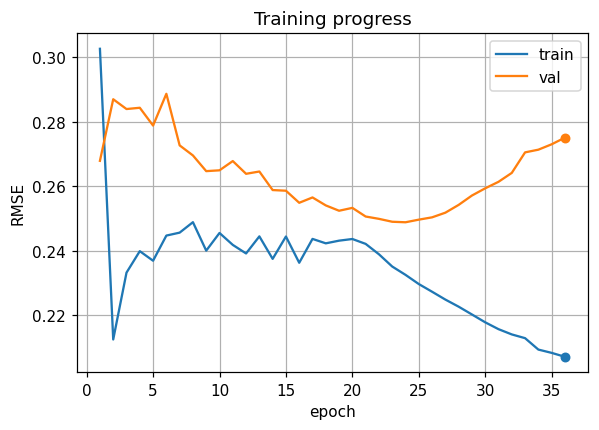

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3027 • val=0.2679 • lr=6.17e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2126 • val=0.2870 • lr=6.16e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2333 • val=0.2840 • lr=6.13e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2399 • val=0.2844 • lr=6.11e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2370 • val=0.2789 • lr=6.07e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2448 • val=0.2887 • lr=6.03e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2457 • val=0.2727 • lr=5.97e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2489 • val=0.2696 • lr=5.91e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2401 • val=0.2648 • lr=5.85e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2456 • val=0.2650 • lr=5.77e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2419 • val=0.2679 • lr=5.69e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2392 • val=0.2639 • lr=5.60e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2445 • val=0.2646 • lr=5.51e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2375 • val=0.2589 • lr=5.41e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2445 • val=0.2587 • lr=5.30e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2363 • val=0.2549 • lr=5.19e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2437 • val=0.2566 • lr=5.07e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2424 • val=0.2541 • lr=4.94e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2432 • val=0.2525 • lr=4.81e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2437 • val=0.2534 • lr=4.68e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2422 • val=0.2507 • lr=4.54e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2390 • val=0.2500 • lr=4.40e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2352 • val=0.2491 • lr=4.26e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2326 • val=0.2489 • lr=4.11e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2297 • val=0.2497 • lr=3.96e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2274 • val=0.2504 • lr=3.81e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2249 • val=0.2519 • lr=3.65e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2227 • val=0.2543 • lr=3.50e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2203 • val=0.2572 • lr=3.34e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2179 • val=0.2594 • lr=3.19e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2158 • val=0.2614 • lr=3.03e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2141 • val=0.2642 • lr=2.88e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2130 • val=0.2706 • lr=2.72e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2094 • val=0.2714 • lr=2.57e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2084 • val=0.2731 • lr=2.41e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2072 • val=0.2751 • lr=2.26e-04
Early stopping at epoch 36


[I 2025-07-30 08:01:52,322] Trial 24 finished with value: 0.24889958527997783 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006171227706205392, 'ETA_MIN': 1.988181315345454e-05, 'WEIGHT_DECAY': 0.00022748847897855335}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 25 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0007001149995174806, 'ETA_MIN': 1.507506480249474e-05, 'WEIGHT_DECAY': 0.00014671179668618507, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



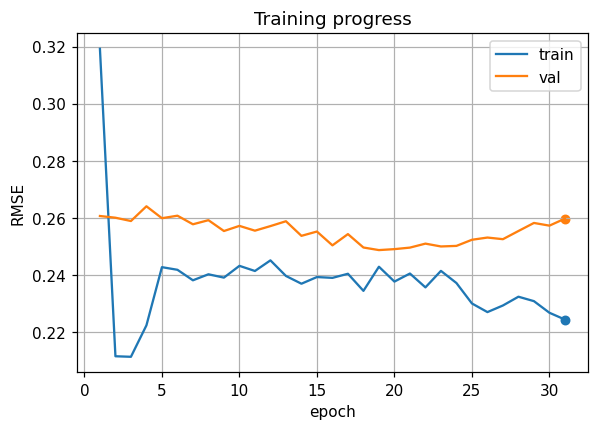

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3192 • val=0.2607 • lr=7.00e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2116 • val=0.2601 • lr=6.98e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2114 • val=0.2589 • lr=6.96e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2224 • val=0.2641 • lr=6.93e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2428 • val=0.2599 • lr=6.89e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2419 • val=0.2608 • lr=6.83e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2382 • val=0.2578 • lr=6.77e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2403 • val=0.2592 • lr=6.71e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2391 • val=0.2554 • lr=6.63e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2433 • val=0.2572 • lr=6.54e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2415 • val=0.2556 • lr=6.45e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2452 • val=0.2572 • lr=6.35e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2397 • val=0.2589 • lr=6.24e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2370 • val=0.2538 • lr=6.12e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2393 • val=0.2553 • lr=6.00e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2390 • val=0.2504 • lr=5.87e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2405 • val=0.2544 • lr=5.73e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2345 • val=0.2497 • lr=5.59e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2429 • val=0.2488 • lr=5.44e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2377 • val=0.2491 • lr=5.29e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2406 • val=0.2496 • lr=5.13e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2357 • val=0.2510 • lr=4.97e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2415 • val=0.2500 • lr=4.81e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2372 • val=0.2502 • lr=4.64e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2301 • val=0.2524 • lr=4.47e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2271 • val=0.2532 • lr=4.29e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2294 • val=0.2526 • lr=4.11e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2324 • val=0.2554 • lr=3.94e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2309 • val=0.2583 • lr=3.76e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2268 • val=0.2573 • lr=3.58e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2245 • val=0.2598 • lr=3.40e-04
Early stopping at epoch 31


[I 2025-07-30 08:26:19,082] Trial 25 finished with value: 0.24876532936093557 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.3, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0007001149995174806, 'ETA_MIN': 1.507506480249474e-05, 'WEIGHT_DECAY': 0.00014671179668618507}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 26 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007843527406354875, 'ETA_MIN': 1.0600647799731065e-05, 'WEIGHT_DECAY': 8.457212040886576e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



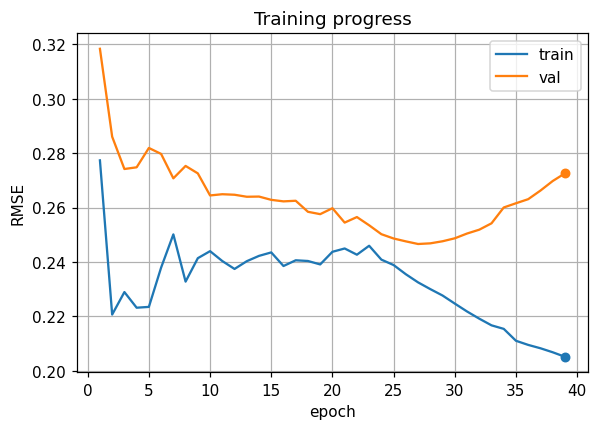

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2774 • val=0.3184 • lr=7.84e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2207 • val=0.2861 • lr=7.82e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2290 • val=0.2742 • lr=7.80e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2232 • val=0.2748 • lr=7.76e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2235 • val=0.2819 • lr=7.71e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2380 • val=0.2797 • lr=7.66e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2502 • val=0.2708 • lr=7.59e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2328 • val=0.2753 • lr=7.51e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2414 • val=0.2726 • lr=7.42e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2440 • val=0.2645 • lr=7.33e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2404 • val=0.2649 • lr=7.22e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2375 • val=0.2647 • lr=7.11e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2403 • val=0.2640 • lr=6.98e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2423 • val=0.2641 • lr=6.85e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2435 • val=0.2629 • lr=6.71e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2385 • val=0.2623 • lr=6.57e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2406 • val=0.2625 • lr=6.41e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2404 • val=0.2585 • lr=6.25e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2391 • val=0.2576 • lr=6.08e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2438 • val=0.2598 • lr=5.91e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2450 • val=0.2545 • lr=5.73e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2427 • val=0.2565 • lr=5.55e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2460 • val=0.2535 • lr=5.36e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2409 • val=0.2502 • lr=5.17e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2389 • val=0.2486 • lr=4.98e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2355 • val=0.2476 • lr=4.78e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2325 • val=0.2466 • lr=4.58e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2300 • val=0.2469 • lr=4.38e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2277 • val=0.2476 • lr=4.18e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2247 • val=0.2487 • lr=3.98e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2218 • val=0.2505 • lr=3.78e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2192 • val=0.2519 • lr=3.57e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2167 • val=0.2542 • lr=3.37e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2154 • val=0.2600 • lr=3.17e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2111 • val=0.2616 • lr=2.98e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2095 • val=0.2631 • lr=2.78e-04


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2083 • val=0.2663 • lr=2.59e-04


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.2068 • val=0.2698 • lr=2.40e-04


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2052 • val=0.2726 • lr=2.22e-04
Early stopping at epoch 39


[I 2025-07-30 08:57:10,649] Trial 26 finished with value: 0.24662670792317504 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0007843527406354875, 'ETA_MIN': 1.0600647799731065e-05, 'WEIGHT_DECAY': 8.457212040886576e-05}. Best is trial 0 with value: 0.24619641677456153.



▶ Trial 27 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006419429524951941, 'ETA_MIN': 8.477061272364749e-06, 'WEIGHT_DECAY': 1.3805471257279111e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



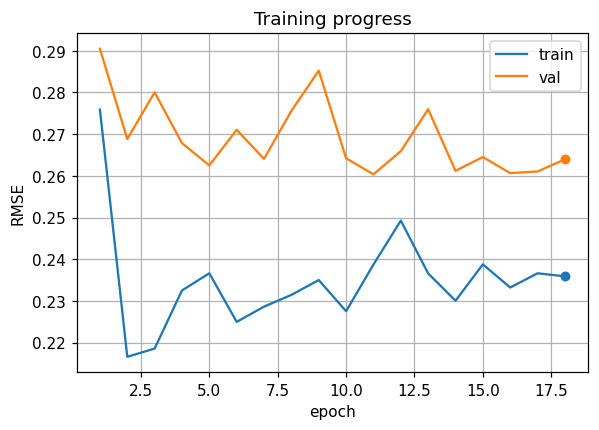

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2759 • val=0.2905 • lr=6.42e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2166 • val=0.2688 • lr=6.40e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2186 • val=0.2800 • lr=6.38e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2325 • val=0.2678 • lr=6.35e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2366 • val=0.2625 • lr=6.31e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2250 • val=0.2710 • lr=6.27e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2286 • val=0.2641 • lr=6.21e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2314 • val=0.2756 • lr=6.15e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2350 • val=0.2852 • lr=6.08e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2275 • val=0.2642 • lr=6.00e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2387 • val=0.2604 • lr=5.91e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2493 • val=0.2659 • lr=5.82e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2366 • val=0.2760 • lr=5.72e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2300 • val=0.2612 • lr=5.61e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2388 • val=0.2645 • lr=5.49e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2332 • val=0.2606 • lr=5.37e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2366 • val=0.2611 • lr=5.25e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2359 • val=0.2640 • lr=5.12e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

[W 2025-07-30 09:11:45,508] Trial 27 failed with parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.0006419429524951941, 'ETA_MIN': 8.477061272364749e-06, 'WEIGHT_DECAY': 1.3805471257279111e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4102/168237911.py", line 69, in objective_train
    best_rmse = models.custom_stateful_training_loop(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py", line 947, in custom_stateful_training_loop
    train_losses.append(loss.item())
                        ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-07-30 09:11:45,570] Trial 27 failed with value None.


KeyboardInterrupt: 

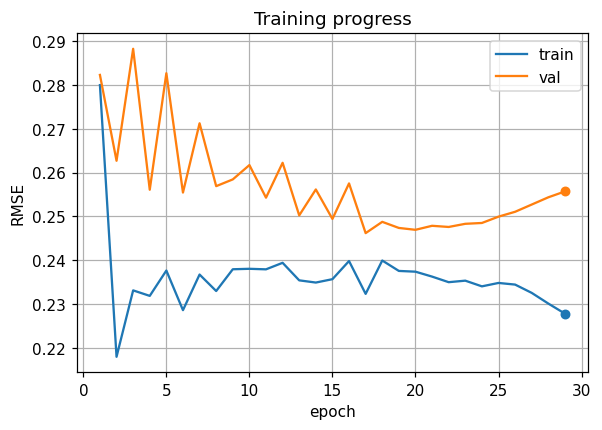

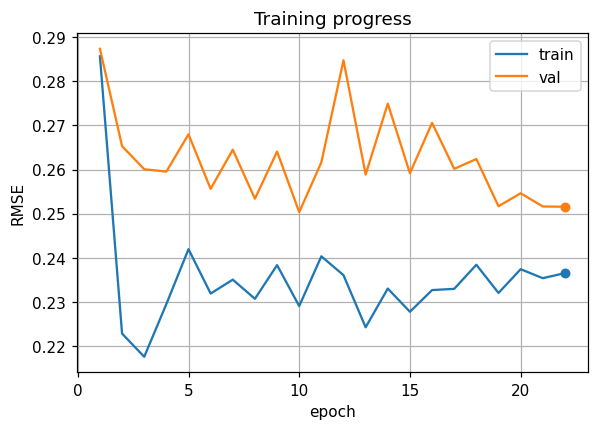

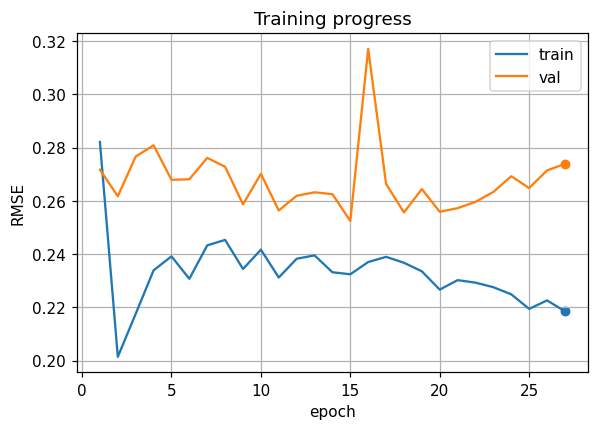

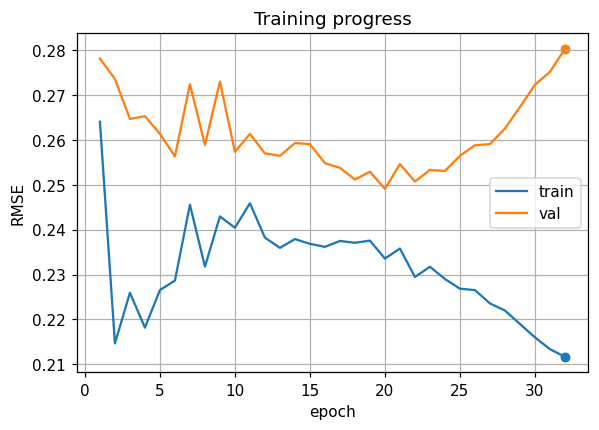

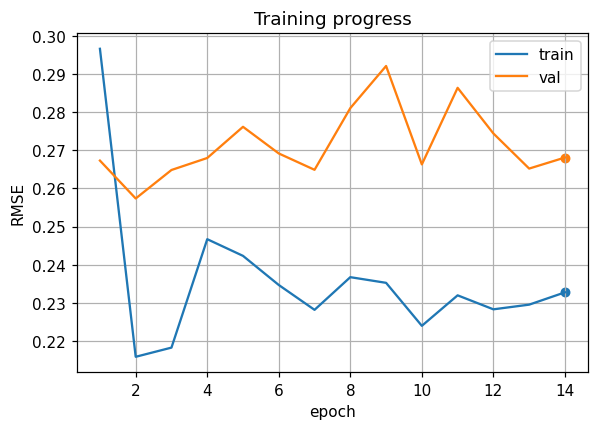

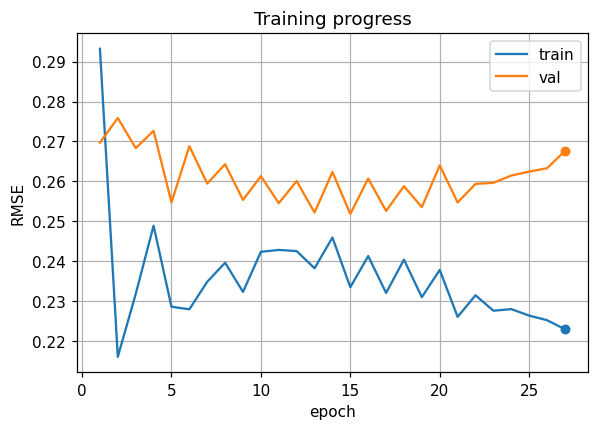

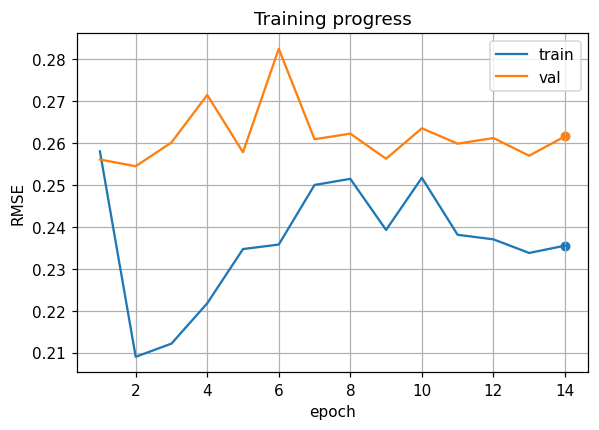

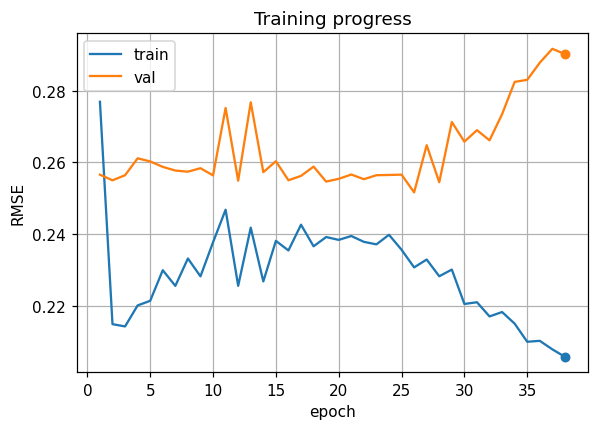

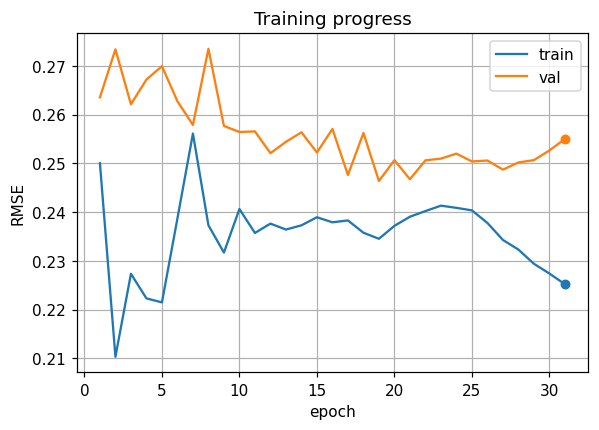

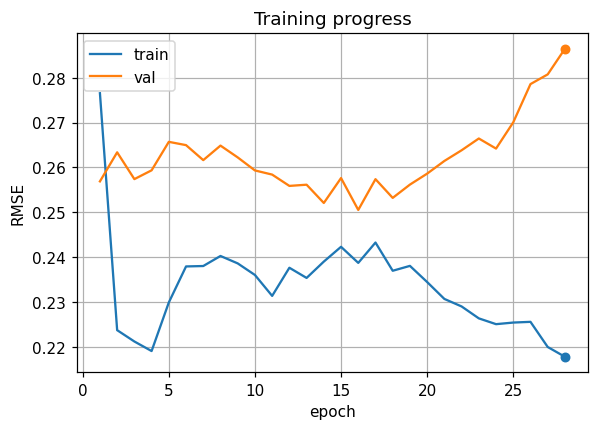

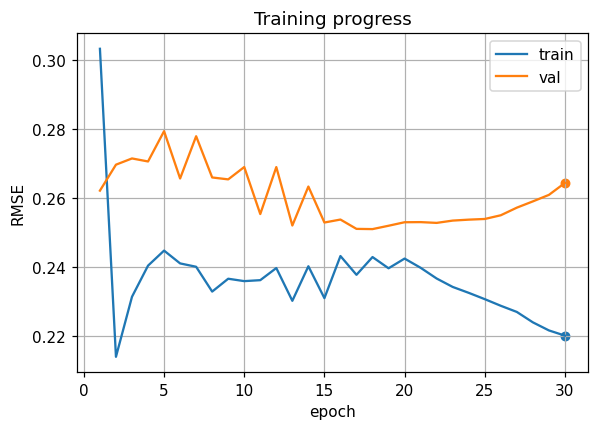

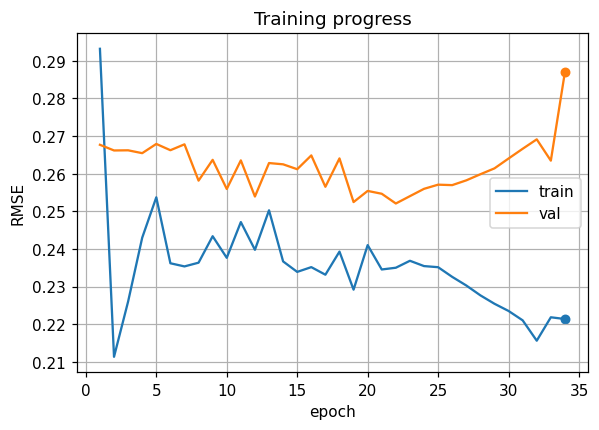

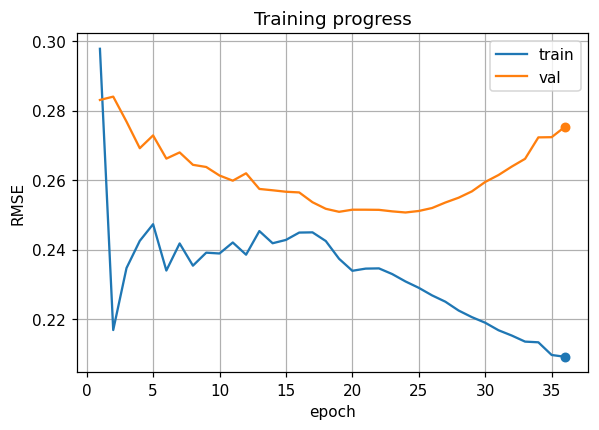

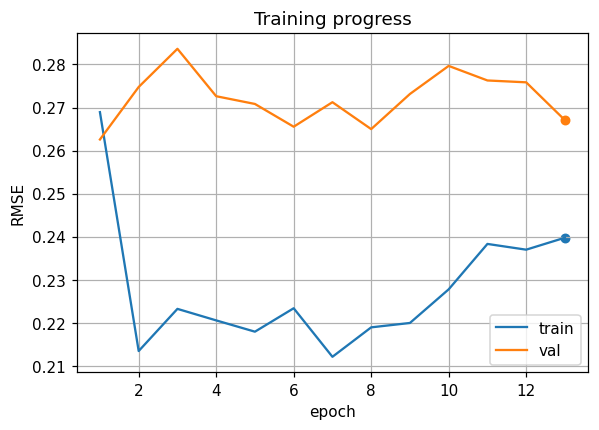

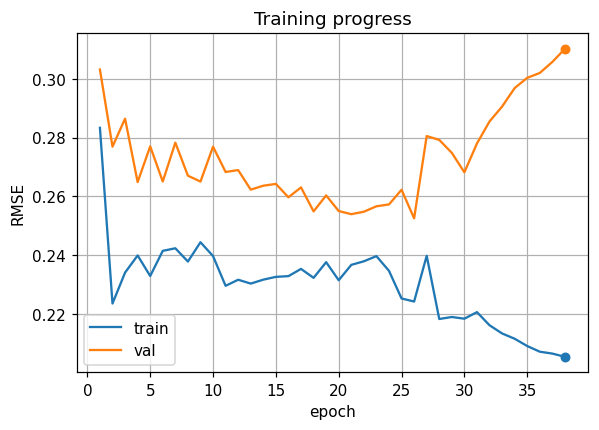

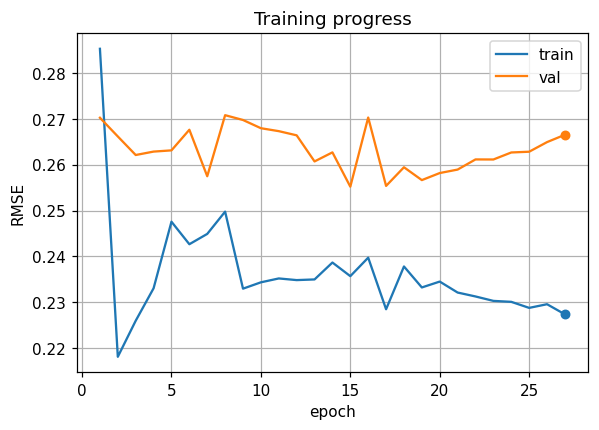

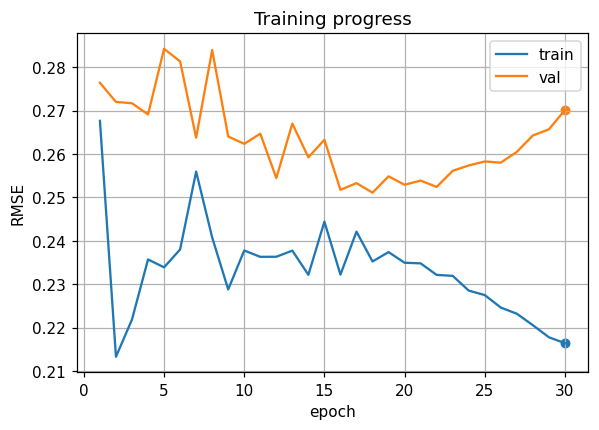

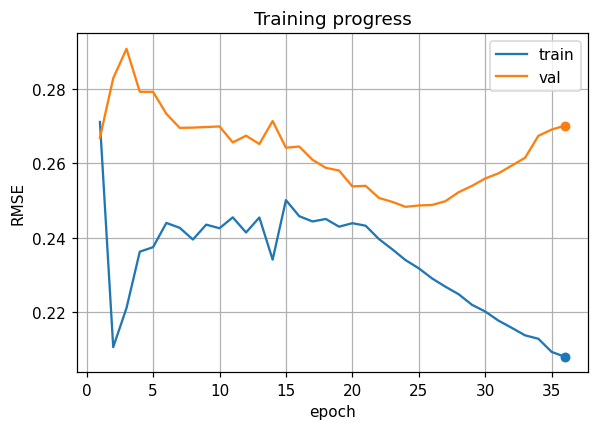

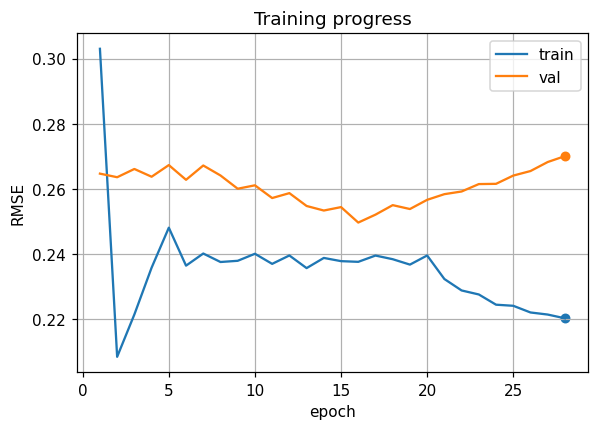

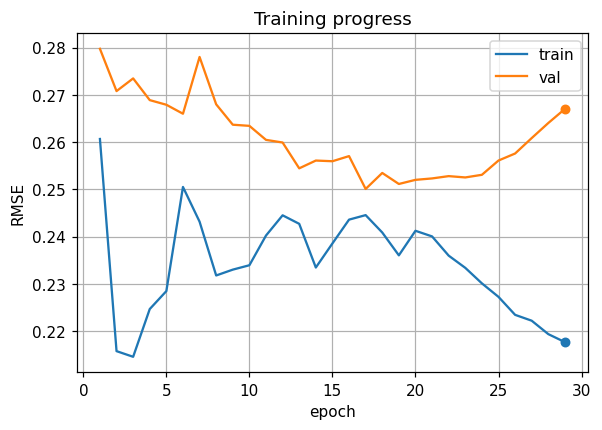

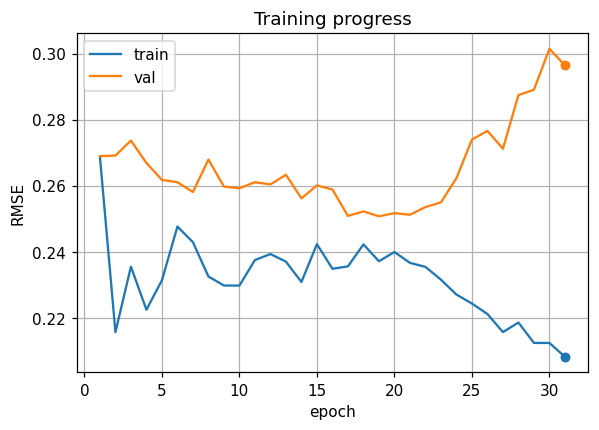

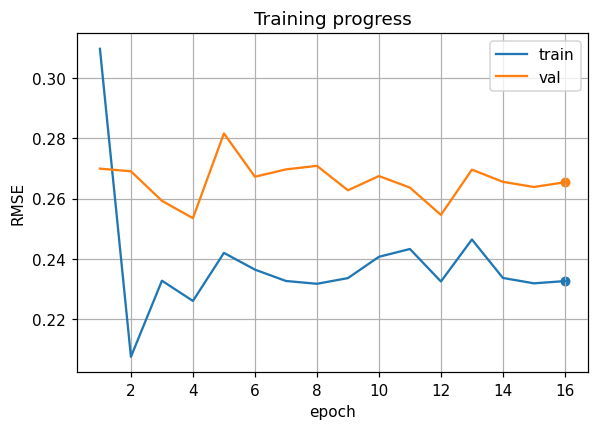

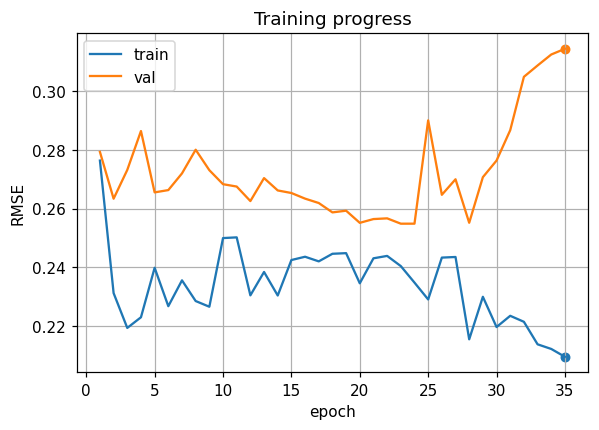

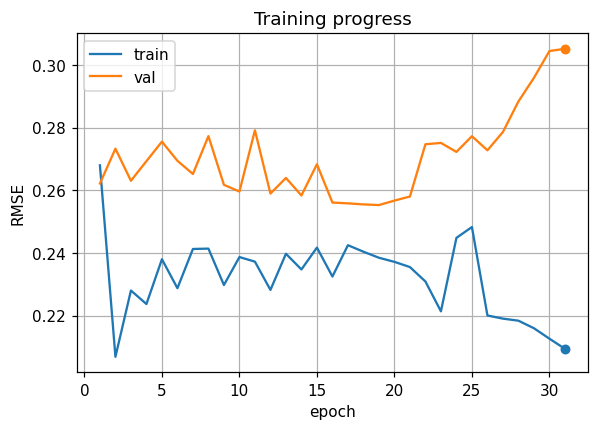

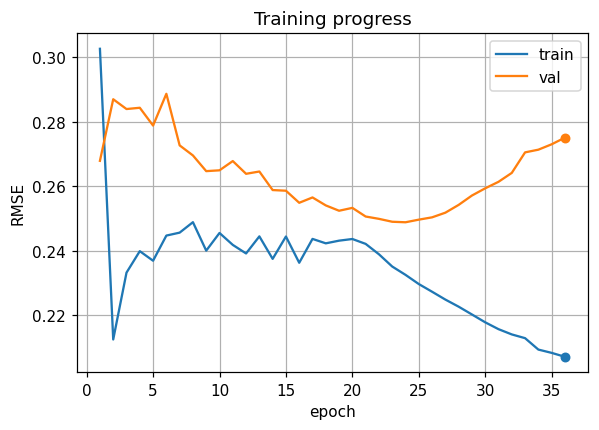

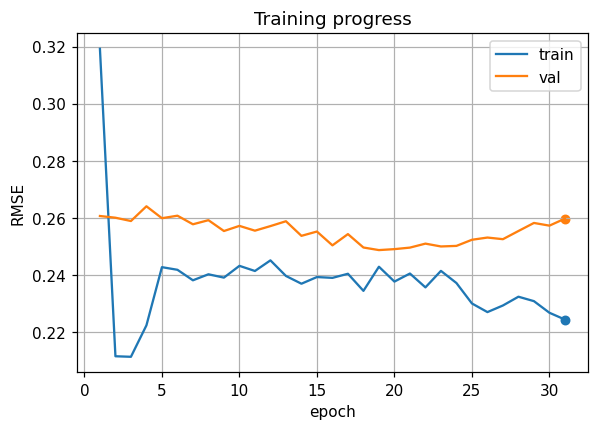

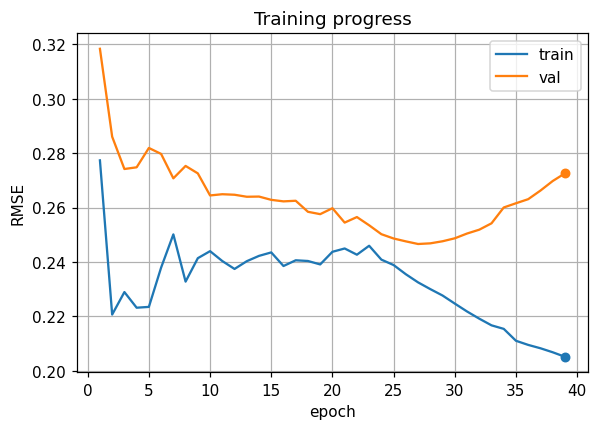

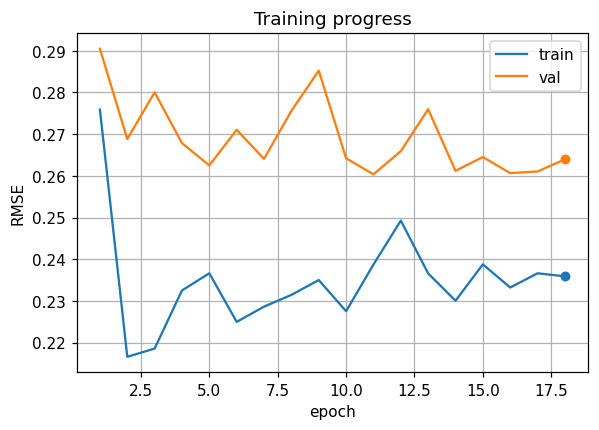

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective_train,
    n_trials = 120,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
